In [2]:
import os
import glob

#data and math
import math
from math import e
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import geopy.distance
import gsw

#plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm #colormap
import matplotlib.patches as patches

In [5]:
#import data from Als model output and observed GP15 data
df_data = pd.read_csv('C:/Users/Becca/Desktop/JP/Pacific Stoichiometry/Data_files/GP15_data_5-20-2021_molarity_updated.csv')
df_data = df_data.dropna(subset = ['dCo [pM]'])

df_model_GP15 = pd.read_csv('C:/Users/Becca/Desktop/JP/GP15/AlsModel/openncfile_table_output_gp15.csv')

df_GP15 = df_data[df_data['Cruise'] == 'GP15']

df_model_GP15

,long_index,lat_index,depth_index,dCo,O2,PO4
0,183,146,1,61.788069,306.826363,0.421988
1,183,145,1,47.278001,304.856211,0.513612
2,184,145,1,47.278001,304.856211,0.513612
3,184,144,1,37.554284,303.384488,0.613917
4,185,144,1,30.971035,303.137383,0.650142
...,...,...,...,...,...,...
2537,188,74,31,NaN,NaN,NaN
2538,188,73,31,NaN,NaN,NaN
2539,188,72,31,NaN,NaN,NaN
2540,188,71,31,NaN,NaN,NaN


In [7]:
#*************** Don't run this code unless you're changing it! It takes a long time! **************   
#************************* Open df_boxes in the cells below instead! *******************************
# GP15
#average data into boxes for comparison between the observed values and the model 

# convert model lat and long indexes to true lat long
df_model_GP15['Model_Latitude'] = df_model_GP15['lat_index'] - 90
df_model_GP15['Model_Longitude'] = df_model_GP15['long_index'] - 360 + 20

#convert Depth_index to Depth
Depth_index_list = [4.9998822, 15.000211, 25.00164, 35.005211, 45.012955, 55.028828, 65.060524, 75.123055, 85.245613, 95.485062,
    105.95201, 116.86147, 128.63055, 142.06528, 158.71194, 181.49471, 215.7935, 271.00211, 361.99203, 508.41904, 728.76904,
    1030.1909, 1403.5045, 1829.5076, 2288.9773, 2767.8115, 3257.2507, 3752.323, 4250.3394, 4749.8813, 5250.2104]
real_Depths_list = []
df_model_GP15_len = df_model_GP15['depth_index'].count()
for index, row in df_model_GP15.head(n=df_model_GP15_len).iterrows():
    real_Depth = Depth_index_list[int(row['depth_index'])-1]
    real_Depths_list.append(real_Depth)
df_model_GP15['Model_Depth'] = real_Depths_list
 
df_model_GP15 = df_model_GP15.rename(columns = {"dCo":"dCo_model"}) 

#define boxes
box_dict = dict()
lat_division = np.arange(-21, 60, 1).tolist()
Depth_division = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 
                  110, 120, 135, 150, 175, 200, 250, 300, 500, 700, 1000, 
                  1250, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500]

l=0
z=0
b=1

for latrange in lat_division:
    if l == len(lat_division) - 1:
        break
    latfloor = lat_division[l]
    latceiling = lat_division[l+1]
    for Depthrange in Depth_division:
        if z == len(Depth_division) - 1:
            z = 0
            l = l+1
        else:
            Depthceiling = Depth_division[z]
            Depthfloor = Depth_division[z+1]
#             print(b, 'lat', latfloor, '-', latceiling, 'DEPTH [m]', Depthceiling, '-', Depthfloor)
            box_dict[b] = [b, latfloor, latceiling, Depthceiling, Depthfloor]
            b = b+1
            z = z+1

#create a dataframe for boxes
b_list = []
latfloor_list = []
latceiling_list = []
Depthceiling_list = []
Depthfloor_list = []
n=1
for boxvalues in box_dict:
    values = box_dict[n]
    b_list.insert(n, values[0])
    latfloor_list.insert(n, values[1])
    latceiling_list.insert(n, values[2])
    Depthceiling_list.insert(n, values[3])
    Depthfloor_list.insert(n, values[4])
    n=n+1
    
df_boxes = pd.DataFrame(box_dict)
df_boxes = df_boxes.transpose()
df_boxes.columns = ['box #', 'latfloor', 'latceiling', 'Depthceiling', 'Depthfloor']

#assign GP15 datapoints to boxes
df_GP15["Box_num"] = np.nan
df_GP15_len = df_GP15['Cruise'].count()
df_boxes_len = df_boxes['box #'].count()
for index, row in df_GP15.head(n=df_GP15_len).iterrows():
    lat_point = row['Latitude']
    Depth_point = row['DEPTH [m]']
    GT_index = index
#     print(matched_index)
    for index, row in df_boxes.head(n=df_boxes_len).iterrows():
        if (lat_point >= row['latfloor']) & (lat_point < row['latceiling']) & (Depth_point >= row['Depthceiling']) & (Depth_point < row['Depthfloor']):
            df_GP15.at[GT_index, 'Box_num'] = row['box #']

#assign model datapoints to boxes
df_model_GP15["Box_num"] = np.nan
df_model_GP15_len = df_model_GP15['depth_index'].count()
df_boxes_len = df_boxes['box #'].count()
for index, row in df_model_GP15.head(n=df_model_GP15_len).iterrows():
    lat_point = row['Model_Latitude']
    Depth_point = row['Model_Depth']
    model_index = index
    for index, row in df_boxes.head(n=df_boxes_len).iterrows():
        if (lat_point >= row['latfloor']) & (lat_point < row['latceiling']) & (Depth_point >= row['Depthceiling']) & (Depth_point < row['Depthfloor']):
            df_model_GP15.at[model_index, 'Box_num'] = row['box #']

#average values in each box
df_groupby = df_GP15.groupby(['Box_num']).mean()
df_groupby_model = df_model_GP15.groupby(['Box_num']).mean()

#add averages to df_boxes
df_boxes["dCo_mean_obs"] = np.nan
df_boxes["O2_mean_obs"] = np.nan
df_boxes["PO4_mean_obs"] = np.nan
df_boxes["dCo_mean_model"] = np.nan
df_boxes["O2_mean_model"] = np.nan
df_boxes["PO4_mean_model"] = np.nan
df_groupby_len = df_groupby['DEPTH [m]'].count()
df_groupby_model_len = df_groupby_model['depth_index'].count()
df_boxes_len = df_boxes['box #'].count()
for index, row in df_boxes.head(n=df_boxes_len).iterrows():
    box_index = index
    #add GP15 averages to df_boxes
    for index, row in df_groupby.head(n=df_groupby_len).iterrows():
        if (index == box_index):
            df_boxes.at[box_index, 'dCo_mean_obs'] = row['dCo [pM]']
            df_boxes.at[box_index, 'O2_mean_obs'] = row['CTDOXY [uM]']
            df_boxes.at[box_index, 'PO4_mean_obs'] = row['Phosphate [uM]']
    #add model averages to df_boxes
    for index, row in df_groupby_model.head(n=df_groupby_model_len).iterrows():
        if (index == box_index):
            df_boxes.at[box_index, 'dCo_mean_model'] = row['dCo_model']
            df_boxes.at[box_index, 'O2_mean_model'] = row['O2']
            df_boxes.at[box_index, 'PO4_mean_model'] = row['PO4']
        
#export df_boxes to csv so I don't need to run the above code every time this notebook opens
# df_boxes.to_csv('C:/Users/Becca/Desktop/JP/GP15/AlsModel/df_boxesGP15.csv', index=False)

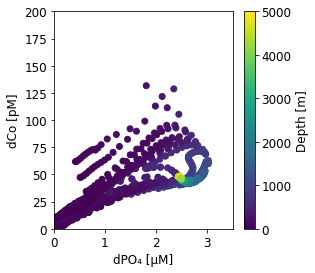

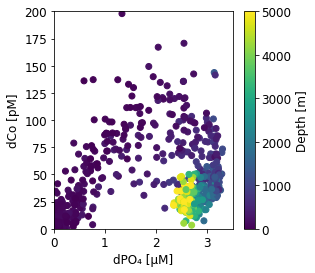

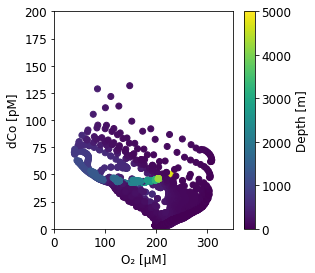

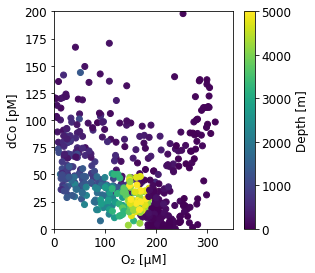

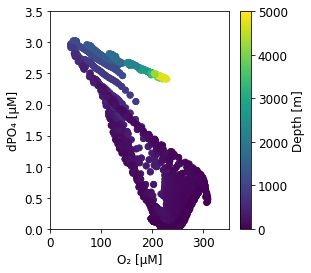

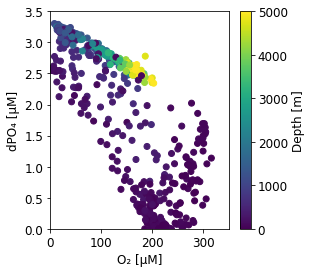

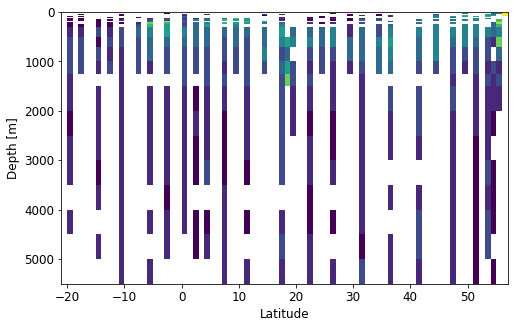

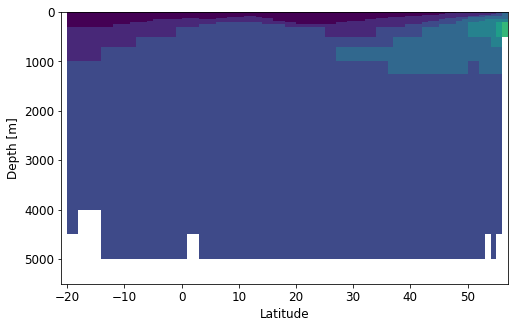

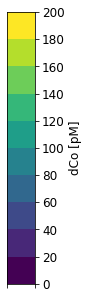

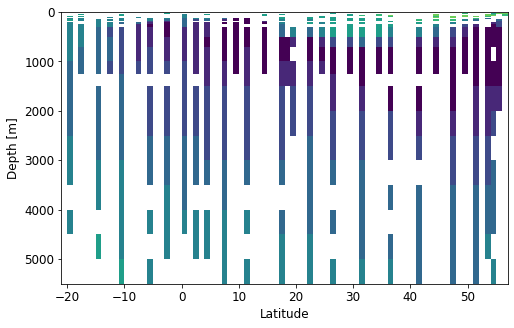

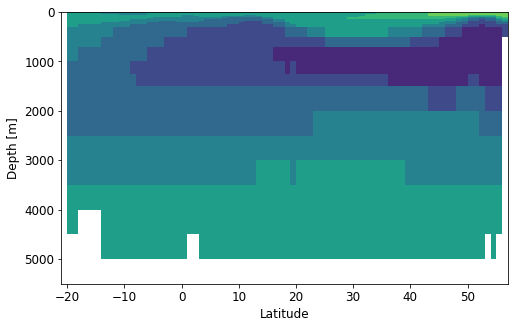

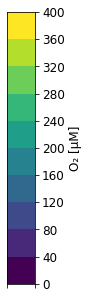

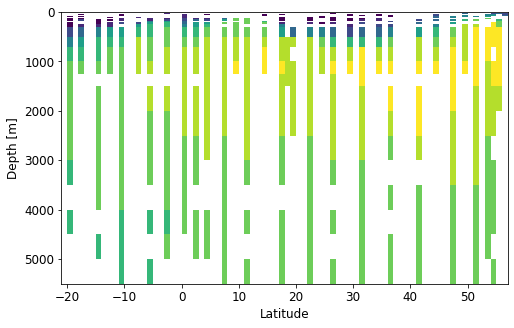

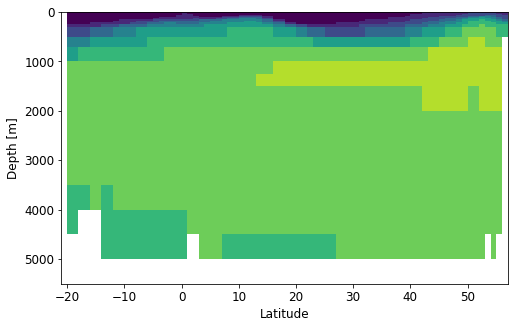

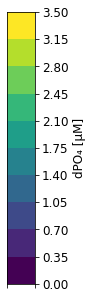

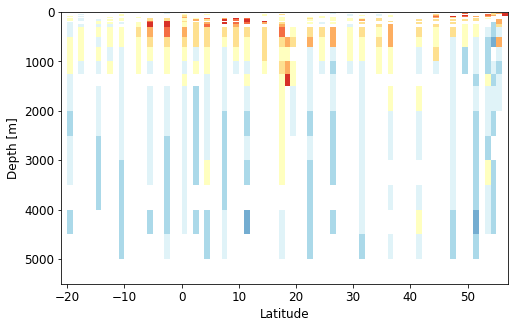

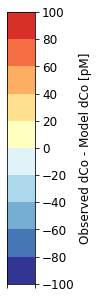

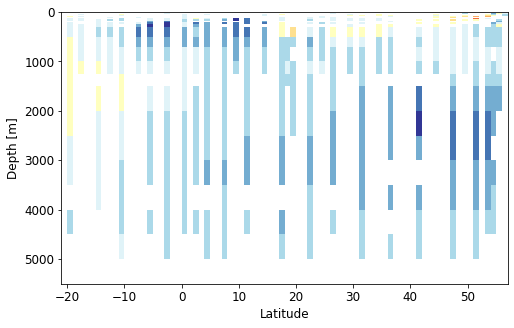

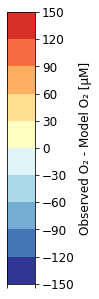

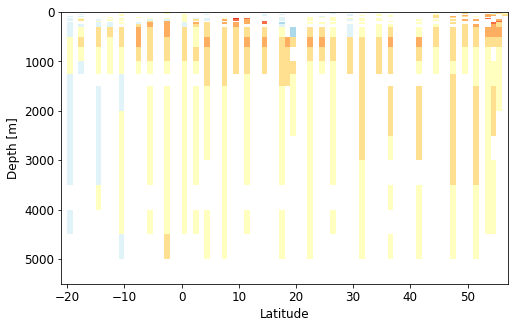

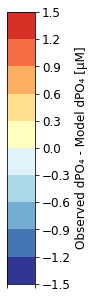

In [11]:
#**************** Run this cell if notebook was just opened! ***********************
#*************************** GP15 *************************************

#import df_boxes from above csv if this notebook was just opened. 
# df_boxes = pd.read_csv('C:/Users/Becca/Desktop/JP/GP15/AlsModel/df_boxesGP15.csv')

#scatter plots of box values - GP15
#Allows for the comparison of slopes between model and observed values

#find average Depth of each box
df_boxes['avg_Depth'] = (df_boxes['Depthfloor'] + df_boxes['Depthceiling'])/2

#dCo vs. PO4 
#Model figure 
x = 'PO4_mean_model'
y = 'dCo_mean_model'
z = 'avg_Depth'
xaxis_label = 'dPO\u2084 [\u03BCM]'
yaxis_label = 'dCo [pM]'
zaxis_label = 'Depth [m]'
z_max = 5000
z_min = 0
font_size = 12
title_font_size = 14
color_scheme = 'viridis'
color3 = 'k'
plt.figure(figsize=(4, 4))
fig = plt.scatter(x, y, c=z, data=df_boxes, cmap=color_scheme, vmin=z_min, vmax = z_max)
plt.ylim(0,200)
plt.xlim(0,3.5)
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/dCo_PO4_model', dpi=600, bbox_inches='tight')
plt.show()

#dCo vs. PO4 
#Observational Figure
x = 'PO4_mean_obs'
y = 'dCo_mean_obs'
z = 'avg_Depth'
xaxis_label = 'dPO\u2084 [\u03BCM]'
yaxis_label = 'dCo [pM]'
zaxis_label = 'Depth [m]'
font_size = 12
title_font_size = 14
color1 = 'midnightblue'
color2 = 'lightseagreen'
color_scheme = 'viridis'
color3 = 'k'
plt.figure(figsize=(4, 4))
fig = plt.scatter(x, y, c=z, data=df_boxes, cmap=color_scheme, vmin=z_min, vmax = z_max)
plt.ylim(0,200)
plt.xlim(0,3.5)
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/dCo_PO4_obs', dpi=600, bbox_inches='tight')
plt.show()

#dCo vs. O2
#Model figure 
x = 'O2_mean_model'
y = 'dCo_mean_model'
z = 'avg_Depth'
xaxis_label = 'O\u2082 [\u03BCM]'
yaxis_label = 'dCo [pM]'
zaxis_label = 'Depth [m]'
z_max = 5000
z_min = 0
font_size = 12
title_font_size = 14
color_scheme = 'viridis'
plt.figure(figsize=(4, 4))
fig = plt.scatter(x, y, c=z, data=df_boxes, cmap=color_scheme, vmin=z_min, vmax = z_max)
plt.ylim(0,200)
plt.xlim(0,350)
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/dCo_O2_model', dpi=600, bbox_inches='tight')
plt.show()

#dCo vs. O2
#Observational Figure
x = 'O2_mean_obs'
y = 'dCo_mean_obs'
z = 'avg_Depth'
xaxis_label = 'O\u2082 [\u03BCM]'
yaxis_label = 'dCo [pM]'
zaxis_label = 'Depth [m]'
font_size = 12
title_font_size = 14
color_scheme = 'viridis'

plt.figure(figsize=(4, 4))
fig = plt.scatter(x, y, c=z, data=df_boxes, cmap=color_scheme, vmin=z_min, vmax = z_max)
plt.ylim(0,200)
plt.xlim(0,350)
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/dCo_O2_obs', dpi=600, bbox_inches='tight')
plt.show()

#PO4 vs. O2
#Model figure 
x = 'O2_mean_model'
y = 'PO4_mean_model'
z = 'avg_Depth'
xaxis_label = 'O\u2082 [\u03BCM]'
yaxis_label = 'dPO\u2084 [\u03BCM]'
zaxis_label = 'Depth [m]'
z_max = 5000
z_min = 0
font_size = 12
title_font_size = 14
color_scheme = 'viridis'
plt.figure(figsize=(4, 4))
fig = plt.scatter(x, y, c=z, data=df_boxes, cmap=color_scheme, vmin=z_min, vmax = z_max)
plt.ylim(0,3.5)
plt.xlim(0,350)
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/dPO4_O2_model', dpi=600, bbox_inches='tight')
plt.show()

#PO4 vs. O2
#Observational Figure
x = 'O2_mean_obs'
y = 'PO4_mean_obs'
z = 'avg_Depth'
xaxis_label = 'O\u2082 [\u03BCM]'
yaxis_label = 'dPO\u2084 [\u03BCM]'
zaxis_label = 'Depth [m]'
font_size = 12
title_font_size = 14
color_scheme = 'viridis'

plt.figure(figsize=(4, 4))
fig = plt.scatter(x, y, c=z, data=df_boxes, cmap=color_scheme, vmin=z_min, vmax = z_max)
plt.ylim(0,3.5)
plt.xlim(0,350)
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/dPO4_O2_obs', dpi=600, bbox_inches='tight')
plt.show()

#box transect of dCo

#box transect of GP15
fig,ax = plt.subplots(1, figsize = (8,5))
plt.ylim(5500, 0)
plt.xlim(-21,57)
plot_of = 'dCo_mean_obs'
xaxis_label = "Latitude"
yaxis_label = 'Depth [m]'
font_size = 12

#Viridis color scheme:
# 1   68 1 84      '#440154'
# 2   72 40 120    '#482878'
# 3   62 74 137    '#3e4a89'
# 4   49 104 142   '#31688e'
# 5   38 130 142   '#26828e'
# 6   31 158 137   '#1f9e89'
# 7   53 183 121   '#35b779'
# 8   109 205 89   '#6dcd59'
# 9   180 222 44   '#b4de2c'
# 10  253 231 37   '#fde725'

df_boxes_dropna = df_boxes.dropna(subset = [plot_of])
color_scheme = ['#440154', '#482878', '#3e4a89', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6dcd59', '#b4de2c', '#fde725']
color_scale = np.arange(0, 201, 20).tolist()
df_boxes_len = df_boxes_dropna['box #'].count()

for index, row in df_boxes_dropna.head(n=df_boxes_len).iterrows():
    x = row['latfloor']
    y = row['Depthfloor']
    width = row['latceiling'] - row['latfloor']
    height = row['Depthceiling'] - row['Depthfloor']
    z = row[plot_of]
    i = 0
    for division in color_scale:
        if i == len(color_scale) - 1:
            break
        elif (z >= color_scale[i]) & (z < color_scale[i+1]):
            color = color_scheme[i]
        elif (z >= color_scale[-1]):
            color = color_scheme[-1]
        else:
            i = i+1
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/dCo_transect_obs', dpi=600, bbox_inches='tight')
plt.show()

# Box transect of model
fig,ax = plt.subplots(1, figsize=(8,5))
plt.ylim(5500, 0)
plt.xlim(-21,57)
plot_of = 'dCo_mean_model'

df_boxes_dropna = df_boxes.dropna(subset = [plot_of])
color_scheme = ['#440154', '#482878', '#3e4a89', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6dcd59', '#b4de2c', '#fde725']
color_scale = np.arange(0, 201, 20).tolist()
df_boxes_len = df_boxes_dropna['box #'].count()

for index, row in df_boxes_dropna.head(n=df_boxes_len).iterrows():
    x = row['latfloor']
    y = row['Depthfloor']
    width = row['latceiling'] - row['latfloor']
    height = row['Depthceiling'] - row['Depthfloor']
    z = row[plot_of]
    i = 0
    for division in color_scale:
        if i == len(color_scale) - 1:
            break
        elif (z >= color_scale[i]) & (z < color_scale[i+1]):
            color = color_scheme[i]
        elif (z >= color_scale[-1]):
            color = color_scheme[-1]
        else:
            i = i+1
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/dCo_transect', dpi=600, bbox_inches='tight')
plt.show()

#Make a colorbar legend
color_scheme = ['#440154', '#482878', '#3e4a89', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6dcd59', '#b4de2c', '#fde725']
color_scale = np.arange(0, 201, 20).tolist()
font_size = 12

fig,ax = plt.subplots(1, figsize=(0.5,5))
plt.ylim(0, 200)
plt.xlim(0,1)
plt.ylabel('dCo [pM]', fontsize=font_size)
ax.set_yticks(color_scale)
plt.tick_params(axis='y', which='major', labelsize=font_size)
plt.setp(ax.get_xticklabels(), visible=False)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

j=0
width = 1
for division in color_scale: 
    x = 0
    y = color_scale[j]
    height = color_scale[j+1] - color_scale[j]
    color = color_scheme[j]
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
    j=j+1
    if j == len(color_scale) - 1:
        break

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/dCo_colorbar', dpi=600, bbox_inches='tight')
plt.show()

#box transect of O2

#box transect of GP15
fig,ax = plt.subplots(1, figsize = (8,5))
plt.ylim(5500, 0)
plt.xlim(-21,57)
plot_of = 'O2_mean_obs'
xaxis_label = "Latitude"
yaxis_label = 'Depth [m]'
font_size = 12

df_boxes_dropna = df_boxes.dropna(subset = [plot_of])
color_scheme = ['#440154', '#482878', '#3e4a89', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6dcd59', '#b4de2c', '#fde725']
color_scale = np.arange(0, 401, 40).tolist()
df_boxes_len = df_boxes_dropna['box #'].count()

for index, row in df_boxes_dropna.head(n=df_boxes_len).iterrows():
    x = row['latfloor']
    y = row['Depthfloor']
    width = row['latceiling'] - row['latfloor']
    height = row['Depthceiling'] - row['Depthfloor']
    z = row[plot_of]
    i = 0
    for division in color_scale:
        if i == len(color_scale) - 1:
            break
        elif (z >= color_scale[i]) & (z < color_scale[i+1]):
            color = color_scheme[i]
        elif (z >= color_scale[-1]):
            color = color_scheme[-1]
        else:
            i = i+1
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/O2_transect_obs', dpi=600, bbox_inches='tight')
plt.show()

# Box transect of model
plot_of = 'O2_mean_model'
df_boxes_dropna = df_boxes.dropna(subset = [plot_of])
df_boxes_len = df_boxes_dropna['box #'].count()

fig,ax = plt.subplots(1, figsize=(8,5))
plt.ylim(5500, 0)
plt.xlim(-21,57)
for index, row in df_boxes_dropna.head(n=df_boxes_len).iterrows():
    x = row['latfloor']
    y = row['Depthfloor']
    width = row['latceiling'] - row['latfloor']
    height = row['Depthceiling'] - row['Depthfloor']
    z = row[plot_of]
    i = 0
    for division in color_scale:
        if i == len(color_scale) - 1:
            break
        elif (z >= color_scale[i]) & (z < color_scale[i+1]):
            color = color_scheme[i]
        elif (z >= color_scale[-1]):
            color = color_scheme[-1]
        else:
            i = i+1
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/O2_transect', dpi=600, bbox_inches='tight')
plt.show()

#Make a colorbar legend
fig,ax = plt.subplots(1, figsize=(0.5,5))
plt.ylim(0, 400)
plt.xlim(0,1)
plt.ylabel('O\u2082 [\u03BCM]', fontsize=font_size)
ax.set_yticks(color_scale)
plt.tick_params(axis='y', which='major', labelsize=font_size)
plt.setp(ax.get_xticklabels(), visible=False)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
j=0
width = 1
for division in color_scale: 
    x = 0
    y = color_scale[j]
    height = color_scale[j+1] - color_scale[j]
    color = color_scheme[j]
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
    j=j+1
    if j == len(color_scale) - 1:
        break
        
# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/O2_colorbar', dpi=600, bbox_inches='tight')
plt.show()

#box transect of PO4

#box transect of GP15
fig,ax = plt.subplots(1, figsize = (8,5))
plt.ylim(5500, 0)
plt.xlim(-21,57)
plot_of = 'PO4_mean_obs'
xaxis_label = "Latitude"
yaxis_label = 'Depth [m]'
font_size = 12

df_boxes_dropna = df_boxes.dropna(subset = [plot_of])
color_scheme = ['#440154', '#482878', '#3e4a89', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6dcd59', '#b4de2c', '#fde725']
color_scale = np.arange(0, 3.6, 0.35).tolist()
df_boxes_len = df_boxes_dropna['box #'].count()

for index, row in df_boxes_dropna.head(n=df_boxes_len).iterrows():
    x = row['latfloor']
    y = row['Depthfloor']
    width = row['latceiling'] - row['latfloor']
    height = row['Depthceiling'] - row['Depthfloor']
    z = row[plot_of]
    i = 0
    for division in color_scale:
        if i == len(color_scale) - 1:
            break
        elif (z >= color_scale[i]) & (z < color_scale[i+1]):
            color = color_scheme[i]
        elif (z >= color_scale[-1]):
            color = color_scheme[-1]
        else:
            i = i+1
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/PO4_transect_obs', dpi=600, bbox_inches='tight')
plt.show()

# Box transect of model
plot_of = 'PO4_mean_model'
df_boxes_dropna = df_boxes.dropna(subset = [plot_of])
df_boxes_len = df_boxes_dropna['box #'].count()

fig,ax = plt.subplots(1, figsize=(8,5))
plt.ylim(5500, 0)
plt.xlim(-21,57)
for index, row in df_boxes_dropna.head(n=df_boxes_len).iterrows():
    x = row['latfloor']
    y = row['Depthfloor']
    width = row['latceiling'] - row['latfloor']
    height = row['Depthceiling'] - row['Depthfloor']
    z = row[plot_of]
    i = 0
    for division in color_scale:
        if i == len(color_scale) - 1:
            break
        elif (z >= color_scale[i]) & (z < color_scale[i+1]):
            color = color_scheme[i]
        elif (z >= color_scale[-1]):
            color = color_scheme[-1]
        else:
            i = i+1
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/PO4_transect', dpi=600, bbox_inches='tight')
plt.show()

#Make a colorbar legend
fig,ax = plt.subplots(1, figsize=(0.5,5))
plt.ylim(0, 3.5)
plt.xlim(0,1)
plt.ylabel('dPO\u2084 [\u03BCM]', fontsize=font_size)
ax.set_yticks(color_scale)
plt.tick_params(axis='y', which='major', labelsize=font_size)
plt.setp(ax.get_xticklabels(), visible=False)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
j=0
width = 1
for division in color_scale: 
    x = 0
    y = color_scale[j]
    height = color_scale[j+1] - color_scale[j]
    color = color_scheme[j]
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
    j=j+1
    if j == len(color_scale) - 1:
        break

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/PO4_colorbar', dpi=600, bbox_inches='tight')
plt.show()
        
df_boxes['dCo_mean_diff'] = df_boxes['dCo_mean_obs'] - df_boxes['dCo_mean_model']
df_boxes['O2_mean_diff'] = df_boxes['O2_mean_obs'] - df_boxes['O2_mean_model']
df_boxes['PO4_mean_diff'] = df_boxes['PO4_mean_obs'] - df_boxes['PO4_mean_model']
df_boxes

#box transect of dCo difference
fig,ax = plt.subplots(1, figsize = (8,5))
plt.ylim(5500, 0)
plt.xlim(-21,57)
plot_of = 'dCo_mean_diff'
xaxis_label = "Latitude"
yaxis_label = 'Depth [m]'
font_size = 12

df_boxes_dropna = df_boxes.dropna(subset = [plot_of])
color_scheme = ["#313695","#4575b4","#74add1","#abd9e9","#e0f3f8","#ffffbf","#fee090","#fdae61","#f46d43","#d73027"]
# color_scheme = ["#d73027","#f46d43","#fdae61","#fee090","#ffffbf","#e0f3f8","#abd9e9","#74add1", "#4575b4","#313695"]
color_scale = np.arange(-100, 101, 20).tolist()
df_boxes_len = df_boxes_dropna['box #'].count()

for index, row in df_boxes_dropna.head(n=df_boxes_len).iterrows():
    x = row['latfloor']
    y = row['Depthfloor']
    width = row['latceiling'] - row['latfloor']
    height = row['Depthceiling'] - row['Depthfloor']
    z = row[plot_of]
    i = 0
    for division in color_scale:
        if i == len(color_scale) - 1:
            break
        elif (z >= color_scale[i]) & (z < color_scale[i+1]):
            color = color_scheme[i]
        elif (z >= color_scale[-1]):
            color = color_scheme[-1]
        else:
            i = i+1
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/dCo_diff', dpi=600, bbox_inches='tight')
plt.show()

#Make a colorbar legend
fig,ax = plt.subplots(1, figsize=(0.5,5))
plt.ylim(-100, 100)
plt.xlim(0,1)
plt.ylabel('Observed dCo - Model dCo [pM]', fontsize=font_size)
ax.set_yticks(color_scale)
plt.tick_params(axis='y', which='major', labelsize=font_size)
plt.setp(ax.get_xticklabels(), visible=False)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
j=0
width = 1
for division in color_scale: 
    x = 0
    y = color_scale[j]
    height = color_scale[j+1] - color_scale[j]
    color = color_scheme[j]
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
    j=j+1
    if j == len(color_scale) - 1:
        break

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/dCo_diff_colorbar', dpi=600, bbox_inches='tight')
plt.show()

#box transect of O2 difference
fig,ax = plt.subplots(1, figsize = (8,5))
plt.ylim(5500, 0)
plt.xlim(-21,57)
plot_of = 'O2_mean_diff'
xaxis_label = "Latitude"
yaxis_label = 'Depth [m]'
font_size = 12

df_boxes_dropna = df_boxes.dropna(subset = [plot_of])
color_scheme = ["#313695","#4575b4","#74add1","#abd9e9","#e0f3f8","#ffffbf","#fee090","#fdae61","#f46d43","#d73027"]
color_scale = np.arange(-150, 151, 30).tolist()
df_boxes_len = df_boxes_dropna['box #'].count()

for index, row in df_boxes_dropna.head(n=df_boxes_len).iterrows():
    x = row['latfloor']
    y = row['Depthfloor']
    width = row['latceiling'] - row['latfloor']
    height = row['Depthceiling'] - row['Depthfloor']
    z = row[plot_of]
    i = 0
    for division in color_scale:
        if i == len(color_scale) - 1:
            break
        elif (z >= color_scale[i]) & (z < color_scale[i+1]):
            color = color_scheme[i]
        elif (z >= color_scale[-1]):
            color = color_scheme[-1]
        else:
            i = i+1
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/O2_diff', dpi=600, bbox_inches='tight')
plt.show()

#Make a colorbar legend
fig,ax = plt.subplots(1, figsize=(0.5,5))
plt.ylim(-150, 150)
plt.xlim(0,1)
plt.ylabel('Observed O\u2082 - Model O\u2082 [\u03BCM]', fontsize=font_size)
ax.set_yticks(color_scale)
plt.tick_params(axis='y', which='major', labelsize=font_size)
plt.setp(ax.get_xticklabels(), visible=False)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
j=0
width = 1
for division in color_scale: 
    x = 0
    y = color_scale[j]
    height = color_scale[j+1] - color_scale[j]
    color = color_scheme[j]
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
    j=j+1
    if j == len(color_scale) - 1:
        break
        
# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/O2_diff_colorbar', dpi=600, bbox_inches='tight')
plt.show()
        
#box transect of PO4 difference
fig,ax = plt.subplots(1, figsize = (8,5))
plt.ylim(5500, 0)
plt.xlim(-21,57)
plot_of = 'PO4_mean_diff'
xaxis_label = "Latitude"
yaxis_label = 'Depth [m]'
font_size = 12

df_boxes_dropna = df_boxes.dropna(subset = [plot_of])
color_scheme = ["#313695","#4575b4","#74add1","#abd9e9","#e0f3f8","#ffffbf","#fee090","#fdae61","#f46d43","#d73027"]
color_scale = np.arange(-1.5, 1.6, 0.3).tolist()
df_boxes_len = df_boxes_dropna['box #'].count()

for index, row in df_boxes_dropna.head(n=df_boxes_len).iterrows():
    x = row['latfloor']
    y = row['Depthfloor']
    width = row['latceiling'] - row['latfloor']
    height = row['Depthceiling'] - row['Depthfloor']
    z = row[plot_of]
    i = 0
    for division in color_scale:
        if i == len(color_scale) - 1:
            break
        elif (z >= color_scale[i]) & (z < color_scale[i+1]):
            color = color_scheme[i]
        elif (z >= color_scale[-1]):
            color = color_scheme[-1]
        else:
            i = i+1
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)

# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/PO4_diff', dpi=600, bbox_inches='tight')
plt.show()

#Make a colorbar legend
fig,ax = plt.subplots(1, figsize=(0.5,5))
plt.ylim(-1.5, 1.5)
plt.xlim(0,1)
plt.ylabel('Observed dPO\u2084 - Model dPO\u2084 [\u03BCM]', fontsize=font_size)
ax.set_yticks(color_scale)
plt.tick_params(axis='y', which='major', labelsize=font_size)
plt.setp(ax.get_xticklabels(), visible=False)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
j=0
width = 1
for division in color_scale: 
    x = 0
    y = color_scale[j]
    height = color_scale[j+1] - color_scale[j]
    color = color_scheme[j]
    rect = patches.Rectangle((x,y),width,height,facecolor=color)
    ax.add_patch(rect)
    j=j+1
    if j == len(color_scale) - 1:
        break
        
# plt.savefig('C:/Users/Becca/Desktop/JP/GP15/Paper/Features Paper/Model Figs/PO4_diff_colorbar', dpi=600, bbox_inches='tight')
plt.show()

In [12]:
df_deep = df_boxes[df_boxes['Depthceiling']>=2000]
print('deep model mean: ', df_deep['dCo_mean_model'].mean())
print('deep obs mean: ', df_deep['dCo_mean_obs'].mean())


deep model mean:  45.39436335729077
deep obs mean:  26.868726297070403
